In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.optim import Adam


from transformers import AutoTokenizer
from transformers import BertModel
from transformers import RobertaModel
from transformers import DistilBertModel
from transformers import DataCollatorWithPadding

from datasets import load_dataset

import matplotlib.pyplot as plt
from IPython.display import clear_output

from tqdm import tqdm

from warnings import filterwarnings

filterwarnings('ignore')

2024-06-07 08:50:17.192521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 08:50:17.192578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 08:50:17.194062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def get_model(model_name):
    assert model_name in ['bert', 'roberta', 'distilbert']
    
     
    checkpoint_names = {
        'bert': 'bert-base-cased',  # https://huggingface.co/bert-base-cased
        'roberta': 'roberta-base',  # https://huggingface.co/roberta-base
        'distilbert': 'distilbert-base-cased'  # https://huggingface.co/distilbert-base-cased
    }
    
    model_classes = {
        'bert': BertModel,
        'roberta': RobertaModel,
        'distilbert': DistilBertModel
    }
    
    return AutoTokenizer.from_pretrained(checkpoint_names[model_name]),model_classes[model_name].from_pretrained(checkpoint_names[model_name])

In [3]:
tokenizer, model = get_model('roberta')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
dataset = load_dataset('imdb')

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [7]:
def tokenization(example):
    return tokenizer.batch_encode_plus(example['text'], return_token_type_ids=False, truncation=True)

train_dataset = dataset['train'].map(tokenization, batched=True)
test_dataset = dataset['test'].map(tokenization, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [8]:
train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 25000
})

In [9]:
train_dataset.set_format(type='torch', columns=['input_ids','attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids','attention_mask', 'label'])

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=data_collator, 
                          pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=data_collator,
                         pin_memory=True, shuffle=False)

In [12]:
@torch.inference_mode()
def get_embeddings_labels(model, loader):
    model.eval()
    
    total_embeddings = []
    labels = []
    
    for batch in tqdm(loader):
        labels.append(batch['labels'].unsqueeze(1))
        
        batch = {key: batch[key].to(device) for key in ['attention_mask', 'input_ids']}
        embeddings = model(**batch)['last_hidden_state'][:, 0, :]
        
        total_embeddings.append(embeddings.cpu())
        
    return torch.cat(total_embeddings, dim=0), torch.cat(labels, dim=0).to(torch.float32)    

In [13]:
train_embeddings, train_labels = get_embeddings_labels(model, train_loader)

100%|██████████| 782/782 [07:21<00:00,  1.77it/s]


In [14]:
test_embeddings, test_labels = get_embeddings_labels(model, test_loader)

100%|██████████| 782/782 [07:20<00:00,  1.78it/s]


In [15]:
dataset = TensorDataset(torch.cat([train_embeddings, test_embeddings], dim=0), torch.cat([train_labels, test_labels], dim=0))

In [16]:
train_dataset, test_dataset = random_split(dataset, (int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)))

train_loader = DataLoader(train_dataset, batch_size=128, pin_memory=True, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=128, pin_memory=True, shuffle=False)

In [17]:
little_model = nn.Sequential(
    nn.Linear(768, 768),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(768, 1)
)

In [18]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(model):
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y).cpu()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    return train_loss, train_accuracy

In [19]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y).cpu()

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy

In [20]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [21]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
        if epoch==(num_epochs-1):
            print(valid_accuracy_history[-1])

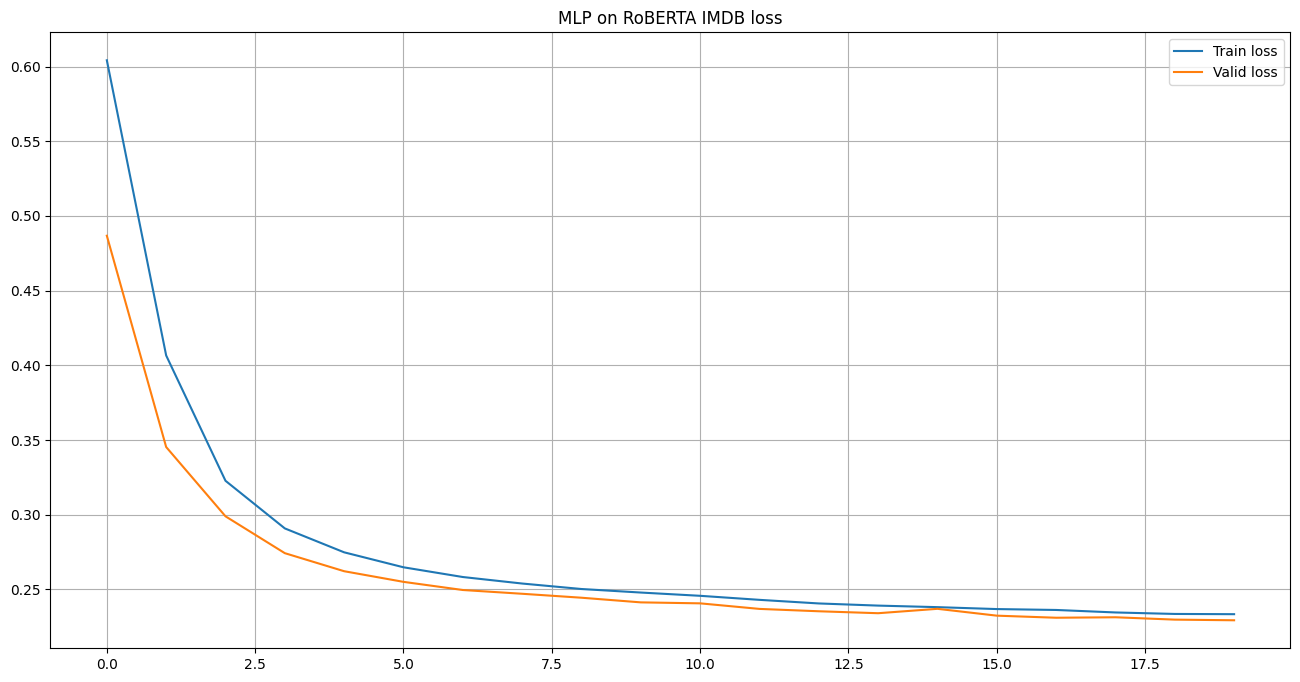

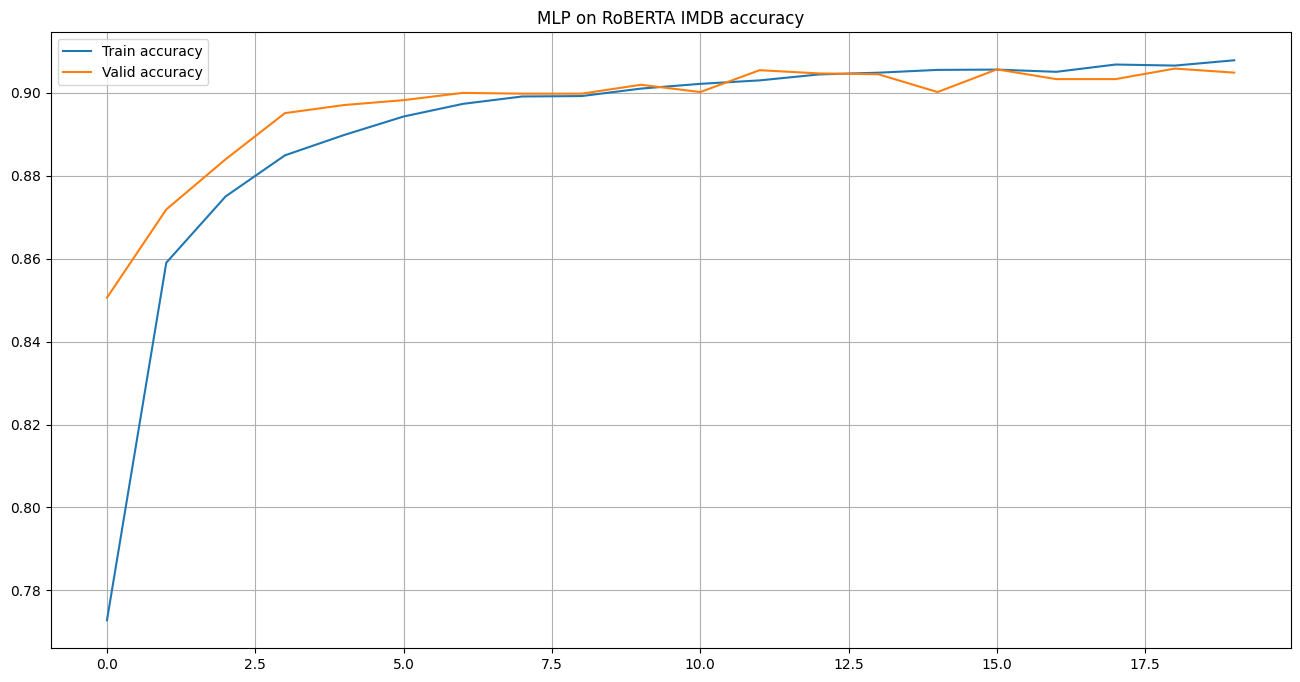

tensor(0.9049)


In [22]:
little_model = little_model.to(device)

optimizer = Adam(little_model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()

whole_train_valid_cycle(little_model, 20, 'MLP on RoBERTA IMDB')